## Rendering with serialized assets

This example explains how to render images with the serialized assets.

In [1]:
import lmenv
env = lmenv.load('.lmenv')

In [2]:
import os
import traceback
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import lightmetrica as lm
%load_ext lightmetrica_jupyter

In [3]:
lm.init()
lm.log.init('jupyter')
lm.progress.init('jupyter')
lm.info()

[I|0.000] Lightmetrica -- Version 3.0.0 (rev. 70601db) Linux x64


In [4]:
if not lm.Release:
    lm.debug.attach_to_debugger()

### Visualizing asset tree

An asset can hold another assets in the instance. As a result, a created set of asset can constitute of an *asset tree*. We can visualize the structure of the tree using ``lm.debug.print_asset_tree()`` function.

In [5]:
accel = lm.load_accel('accel', 'sahbvh')
scene = lm.load_scene('scene', 'default', accel=accel)

[I|0.012] Loading asset [name='accel']
[I|0.012] Loading asset [name='scene']


In [6]:
lm.debug.print_asset_tree()

[I|0.019] $.assets
[I|0.020] .. .accel [accel::sahbvh]
[I|0.020] .. .scene [scene::default]


In [7]:
# Clear the internal state
lm.reset()
lm.debug.print_asset_tree()

[I|0.026] $.assets


### Asset group

*Asset group* is a special type of asset that can hold multiple instance of assets. By means of the asset group, we can hierarchcally manage the assets. Asset group can be created by ``lm.load_asset_group()`` function.

In [8]:
g = lm.load_asset_group('fireplace_room', 'default')

[I|0.032] Loading asset [name='fireplace_room']


An another asset can be loaded as a child of the asset group by calling ``lm.AssetGroup.load_*()`` member functions. The arguments are same as ``lm.load_*()`` functions. Note that the locator of the asset includes the id of the group.

In [9]:
camera = g.load_camera('camera1', 'pinhole', 
    position=[5.101118, 1.083746, -2.756308],
    center=[4.167568, 1.078925, -2.397892],
    up=[0,1,0],
    vfov=43.001194,
    aspect=16/9)
model = g.load_model('model', 'wavefrontobj',
    path=os.path.join(env.scene_path, 'fireplace_room/fireplace_room.obj'))
accel = g.load_accel('accel', 'sahbvh')
scene = g.load_scene('scene', 'default', accel=accel)
scene.add_primitive(camera=camera)
scene.add_primitive(model=model)
scene.build()

[I|0.041] Loading asset [name='camera1']
[I|0.041] Loading asset [name='model']
[I|0.041] .. Loading OBJ file [path='fireplace_room.obj']
[I|0.041] .. Loading MTL file [path='fireplace_room.mtl']


[I|0.367] .. Loading texture [path='wood.ppm']
[I|0.457] .. Loading texture [path='leaf.ppm']
[I|0.459] .. Loading texture [path='picture8.ppm']
[I|0.491] .. Loading texture [path='wood5.ppm']
[I|0.543] Loading asset [name='accel']
[I|0.543] Loading asset [name='scene']
[I|0.546] Building acceleration structure [name='accel']
[I|0.546] .. Flattening scene
[I|0.574] .. Building


In [10]:
lm.debug.print_asset_tree()

[I|1.200] $.assets
[I|1.200] .. .fireplace_room [asset_group::default]
[I|1.201] .... .camera1 [camera::pinhole]
[I|1.201] .... .model [model::wavefrontobj]
[I|1.201] ...... .grey_and_white_room:BottleCap [material::mixture_wavefrontobj]
[I|1.201] ........ .diffuse [material::diffuse]
[I|1.201] ........ .glossy [material::glossy]
[I|1.201] ...... .grey_and_white_room:Branches [material::mixture_wavefrontobj]
[I|1.201] ........ .diffuse [material::diffuse]
[I|1.201] ........ .glossy [material::glossy]
[I|1.201] ...... .grey_and_white_room:BrushedStainlessSteel [material::mixture_wavefrontobj]
[I|1.201] ........ .diffuse [material::diffuse]
[I|1.201] ........ .glossy [material::glossy]
[I|1.201] ...... .grey_and_white_room:Dirt [material::mixture_wavefrontobj]
[I|1.201] ........ .diffuse [material::diffuse]
[I|1.202] ........ .glossy [material::glossy]
[I|1.202] ...... .grey_and_white_room:FireplaceGlass [material::mixture_wavefrontobj]
[I|1.202] ........ .diffuse [material::diffuse]
[I|

### Serialization of asset

An asset can be serialized into a disk as a binary stream. For instance, it is useful to accelerate the loading time of the assets in debug mode or in the repetitive experiments, since we can skip the precomputation along with loading of the asset.

Serialization to a file can be done by ``lm.Component.save_to_file()`` function. We give the path to the output file as an argument.

In [11]:
g.save_to_file('fireplace_room.serialized')

In [12]:
# Reset the internal state
lm.reset()
lm.debug.print_asset_tree()

[I|1.549] $.assets


Note that serializing aseet group means serializing a subtree of the entire asset tree. The serialization process can fail if an asset being serialized (incl. child assets) contains external reference out of the subtree. 

In [13]:
accel = lm.load_accel('accel', 'sahbvh')
g = lm.load_asset_group('fireplace_room', 'default')
scene = g.load_scene('scene', 'default', accel=accel)
lm.debug.print_asset_tree()

[I|1.557] Loading asset [name='accel']
[I|1.558] Loading asset [name='fireplace_room']
[I|1.558] Loading asset [name='scene']
[I|1.558] $.assets
[I|1.558] .. .accel [accel::sahbvh]
[I|1.558] .. .fireplace_room [asset_group::default]
[I|1.558] .... .scene [scene::default]


In [14]:
# Serialization will fail because
# accel is out of the subtree starting from g as a root.
try:
    g.save_to_file('failed.serialized')
except Exception:
    traceback.print_exc()

Traceback (most recent call last):
  File "/tmp/ipykernel_206/1972952766.py", line 4, in <module>
    g.save_to_file('failed.serialized')
pylm.Exception: Unserializable asset. Subtree contains a reference to the outer asset. [loc='$.assets.accel'] [err='Unsupported']


In [15]:
# Reset the internal state
lm.reset()
lm.debug.print_asset_tree()

[I|1.572] $.assets


### Loading serialized asset

The serialized asset can be loaded by ``lm.load_serialized()`` funcction, where the first argument specifies the id of the asset and the second argument specifies the path to the serialized asset. Note that the id of the asset can be not always the same from the original asset before serialization.

In [16]:
lm.load_serialized('fireplace_room', 'fireplace_room.serialized')

[I|1.578] Loading serialized asset [name='fireplace_room']


In [17]:
lm.debug.print_asset_tree()

[I|1.871] $.assets
[I|1.871] .. .fireplace_room [asset_group::default]
[I|1.871] .... .camera1 [camera::pinhole]
[I|1.871] .... .model [model::wavefrontobj]
[I|1.871] ...... .grey_and_white_room:BottleCap [material::mixture_wavefrontobj]
[I|1.871] ........ .diffuse [material::diffuse]
[I|1.871] ........ .glossy [material::glossy]
[I|1.871] ...... .grey_and_white_room:Branches [material::mixture_wavefrontobj]
[I|1.871] ........ .diffuse [material::diffuse]
[I|1.871] ........ .glossy [material::glossy]
[I|1.871] ...... .grey_and_white_room:BrushedStainlessSteel [material::mixture_wavefrontobj]
[I|1.871] ........ .diffuse [material::diffuse]
[I|1.871] ........ .glossy [material::glossy]
[I|1.871] ...... .grey_and_white_room:Dirt [material::mixture_wavefrontobj]
[I|1.871] ........ .diffuse [material::diffuse]
[I|1.871] ........ .glossy [material::glossy]
[I|1.871] ...... .grey_and_white_room:FireplaceGlass [material::mixture_wavefrontobj]
[I|1.871] ........ .diffuse [material::diffuse]
[I|

In [18]:
# Reset the internal state
lm.reset()
lm.debug.print_asset_tree()

[I|1.898] $.assets


Also note that the serialized asset can be loaded in a different location in the asset tree, for instance, as a child of the different asset group. 

In [19]:
g = lm.load_asset_group('another_group', 'default')
g.load_serialized('fireplace_room', 'fireplace_room.serialized')
lm.debug.print_asset_tree()

[I|1.906] Loading asset [name='another_group']
[I|1.906] Loading serialized asset [name='fireplace_room']
[I|2.190] $.assets
[I|2.191] .. .another_group [asset_group::default]
[I|2.191] .... .fireplace_room [asset_group::default]


[I|2.191] ...... .camera1 [camera::pinhole]
[I|2.191] ...... .model [model::wavefrontobj]
[I|2.191] ........ .grey_and_white_room:BottleCap [material::mixture_wavefrontobj]
[I|2.191] .......... .diffuse [material::diffuse]
[I|2.191] .......... .glossy [material::glossy]
[I|2.191] ........ .grey_and_white_room:Branches [material::mixture_wavefrontobj]
[I|2.191] .......... .diffuse [material::diffuse]
[I|2.191] .......... .glossy [material::glossy]
[I|2.191] ........ .grey_and_white_room:BrushedStainlessSteel [material::mixture_wavefrontobj]
[I|2.191] .......... .diffuse [material::diffuse]
[I|2.191] .......... .glossy [material::glossy]
[I|2.191] ........ .grey_and_white_room:Dirt [material::mixture_wavefrontobj]
[I|2.191] .......... .diffuse [material::diffuse]
[I|2.191] .......... .glossy [material::glossy]
[I|2.192] ........ .grey_and_white_room:FireplaceGlass [material::mixture_wavefrontobj]
[I|2.192] .......... .diffuse [material::diffuse]
[I|2.192] .......... .glossy [material::gl

### Rendering with serialized asset

We can render the image using the serializaed asset. Here we are using a locator directly instead of passing the instance, since the previously obtained reference (``scene``) became invalid.

In [20]:
# Rendering
film = lm.load_film('film', 'bitmap', w=1920, h=1080)
renderer = lm.load_renderer('renderer', 'pt',
    scene='$.assets.another_group.fireplace_room.scene',
    output=film,
    scheduler='sample',
    spp=1,
    max_verts=20)
renderer.render()

[I|2.213] Loading asset [name='film']
[I|2.291] Loading asset [name='renderer']


  0%|          | 0/2073600 [00:00<?, ?it/s]

{'elapsed': 44.076678315, 'processed': 1}

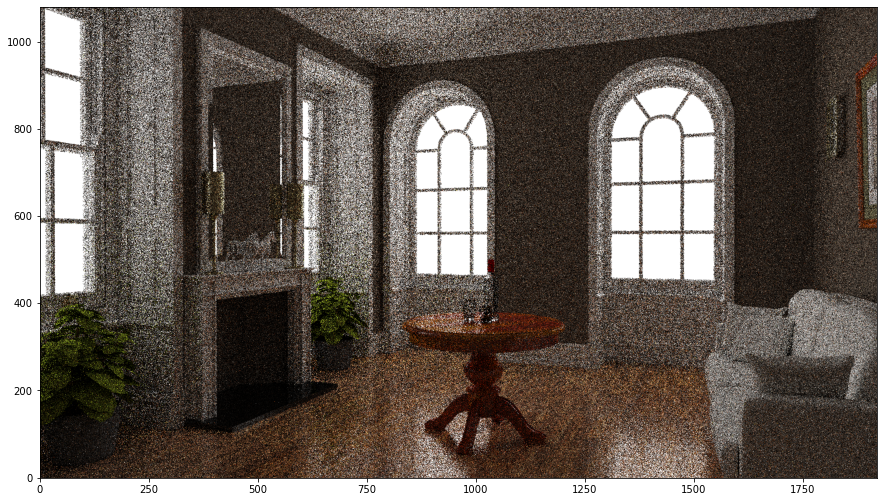

In [21]:
img = np.copy(film.buffer())
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111)
ax.imshow(np.clip(np.power(img,1/2.2),0,1), origin='lower')
plt.show()